In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import datetime
from datetime import datetime as dtm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import math
from torch.utils.data import random_split
import time
from torch.utils.tensorboard import SummaryWriter
import os
import shutil
from IPython.display import FileLink
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

In [2]:
myTransform = transforms.Compose([
    #comment out resize to use SimpleNet
    transforms.Resize((227,227)),
    
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

### Neural Network Classes

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 100, dropout: float = 0.5):
        super().__init__()
        self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(64, 192, kernel_size=5, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(192, 384, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(384, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.classifier = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(256 * 6 * 6, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout),
                nn.Linear(4096, 1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, num_classes),
            )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
class AlexNet_mod(nn.Module):
    def __init__(self, num_classes: int = 100, dropout: float = 0.5):
        super().__init__()
        self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
                nn.Tanh(),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(64, 192, kernel_size=5, padding=2),
                nn.Tanh(),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(192, 384, kernel_size=3, padding=1),
                nn.Tanh(),
                nn.Conv2d(384, 256, kernel_size=3, padding=1),
                nn.Tanh(),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.Tanh(),
                nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.classifier = nn.Sequential(
                nn.Dropout(p=dropout),
                nn.Linear(256 * 6 * 6, 4096),
                nn.Tanh(),
                nn.Dropout(p=dropout),
                nn.Linear(4096, 1024),
                nn.Tanh(),
                nn.Linear(1024, num_classes),
            )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [5]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
class SimpleNet_mod(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

### Argument Object

In [7]:
class ArgObj(object):
    _defaults = {
        "max_epochs": 50,
        "patience": 3,
        "device": "cuda",
        "seed": 42,
        "lr": 0.01,
        "momentum": 0.7,
        "batch_size": 32,
        "n_classes": 100,
        "dropout": 0.5,
        "log_interval": 10,
    }

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults)
        self.__dict__.update(kwargs)


my_args = ArgObj()

print(vars(my_args))

{'max_epochs': 50, 'patience': 3, 'device': 'cuda', 'seed': 42, 'lr': 0.01, 'momentum': 0.7, 'batch_size': 32, 'n_classes': 100, 'dropout': 0.5, 'log_interval': 10}


### Dataset, Loaders, Split

In [8]:
train_dataset = torchvision.datasets.CIFAR100(root='./root', train=True,
                                              transform=myTransform, download=True)
test_val_dataset = torchvision.datasets.CIFAR100(root='./root', train=False,
                                              transform=myTransform, download=True) 

gnr = torch.Generator().manual_seed(my_args.seed)

test_dataset, val_dataset = random_split(test_val_dataset, [0.5, 0.5], generator=gnr)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=my_args.batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=my_args.batch_size, shuffle=False)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=my_args.batch_size, shuffle=False)

examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./root/cifar-100-python.tar.gz to ./root
Files already downloaded and verified
torch.Size([32, 3, 227, 227]) torch.Size([32])


### Class Hierarchy Management

In [9]:
def create_superclass(x):
    fine_id_coarse_id = {0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3, 10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11, 16: 3, 17: 9, 18: 7, 19: 11, 20: 6, 21: 11, 22: 5, 23: 10, 24: 7, 25: 6, 26: 13, 27: 15, 28: 3, 29: 15, 30: 0,
                         31: 11, 32: 1, 33: 10, 34: 12, 35: 14, 36: 16,
                         37: 9, 38: 11, 39: 5, 40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13, 46: 14, 47: 17, 48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2, 55: 0, 56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12, 64: 12, 65: 16,
                         66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10, 72: 0, 73: 1, 74: 16,
                         75: 12, 76: 9, 77: 13, 78: 15, 79: 13, 80: 16, 81: 19, 82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5, 88: 8, 89: 19, 90: 18, 91: 1, 92: 2, 93: 15, 94: 6, 95: 0, 96: 17, 97: 8, 98: 14, 99: 13}
    return fine_id_coarse_id[x]


v_create_superclass = np.vectorize(create_superclass)


def create_ultraclass(x):
    coarse_id_ultra_id = {0: 0, 1: 4, 2: 1, 3: 2, 4: 1, 5: 2, 6: 2, 7: 3, 8: 4, 9: 6, 10: 6, 11: 4, 12: 0, 13: 3, 14: 0, 15: 4, 16: 0, 17: 6, 18: 5, 19: 5}
    return coarse_id_ultra_id[x]


v_create_ultraclass = np.vectorize(create_ultraclass)


def get_labels(idx, level='super'):
    labels = {
        'ultra': ['mammal', 'plant', 'household', 'invertebrates', 'other animal', 'vehicles', 'nature'],

        'super': ['aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit & vegetables',
                  'household electrical device', 'household furniture', 'insects', 'large carnivores',
                  'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores',
                  'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2'
                  ],
        'sub': [
            'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
            'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
            'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
            'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
            'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
            'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
            'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
            'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
            'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
            'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
            'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
            'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
            'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
            'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
            'worm'
        ]
    }
    return labels[level][idx]

### Data Exploration

In [10]:
examples = iter(train_loader)
samples, labels = next(examples)

sup = v_create_superclass(labels)
ult = v_create_ultraclass(sup)

levels = [labels, sup, ult]
level_names = ["sub", "super", "ultra"]

for i in range(10):
    for j in range(3):
        a = levels[j][i]
        print(get_labels(a, level=level_names[j]), end=" | ")
    print("\n")

chair | household furniture | household | 

tulip | flowers | plant | 

possum | medium-sized mammals | mammal | 

apple | fruit & vegetables | plant | 

forest | large natural outdoor scenes | nature | 

orchid | flowers | plant | 

aquarium_fish | fish | other animal | 

skyscraper | large man-made outdoor things | nature | 

mushroom | fruit & vegetables | plant | 

trout | fish | other animal | 



In [11]:
labs = range(100)

#sorted by index - ultra class first key, superclass second
sorted_labels = sorted(labs, key= lambda x: (create_ultraclass(create_superclass(x)), create_superclass(x)))

for i in sorted_labels:
    print(f"{get_labels(i, 'sub')}|{get_labels(create_superclass(i), 'super')}|{get_labels(create_ultraclass(create_superclass(i)), 'ultra')}")

beaver|aquatic mammals|mammal
dolphin|aquatic mammals|mammal
otter|aquatic mammals|mammal
seal|aquatic mammals|mammal
whale|aquatic mammals|mammal
fox|medium-sized mammals|mammal
porcupine|medium-sized mammals|mammal
possum|medium-sized mammals|mammal
raccoon|medium-sized mammals|mammal
skunk|medium-sized mammals|mammal
baby|people|mammal
boy|people|mammal
girl|people|mammal
man|people|mammal
woman|people|mammal
hamster|small mammals|mammal
mouse|small mammals|mammal
rabbit|small mammals|mammal
shrew|small mammals|mammal
squirrel|small mammals|mammal
orchid|flowers|plant
poppy|flowers|plant
rose|flowers|plant
sunflower|flowers|plant
tulip|flowers|plant
apple|fruit & vegetables|plant
mushroom|fruit & vegetables|plant
orange|fruit & vegetables|plant
pear|fruit & vegetables|plant
sweet_pepper|fruit & vegetables|plant
bottle|food containers|household
bowl|food containers|household
can|food containers|household
cup|food containers|household
plate|food containers|household
clock|household el

In [12]:
ult = v_create_ultraclass(v_create_superclass(sorted_labels))

for i in np.unique(ult):
    print(f'{get_labels(i, "ultra"):<10} \t {list(ult).count(i):>10}\n____________________________')

mammal     	         20
____________________________
plant      	         10
____________________________
household  	         15
____________________________
invertebrates 	         10
____________________________
other animal 	         20
____________________________
vehicles   	         10
____________________________
nature     	         15
____________________________


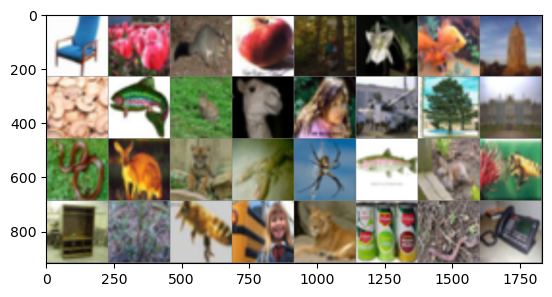

chair | tulip | possum | apple | forest | orchid | aquarium_fish | skyscraper
mushroom | trout | rabbit | camel | girl  | tank  | pine_tree | castle
snake | kangaroo | tiger | lobster | spider | trout | squirrel | bee  
wardrobe | willow_tree | bee   | bus   | lion  | can   | worm  | telephone



In [13]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(samples))
# print labels

def line_break(x):
    return [' | ', "\n"][(x+1) % 8 == 0 and x>0]
    
print(''.join(f'{get_labels(labels[i], "sub"):5s}{line_break(i)}' for i in range(len(labels))))

### Training 1 epoch, Test, Inference Functions

In [14]:
criterion_mean = nn.CrossEntropyLoss(reduction='mean')
criterion_sum = nn.CrossEntropyLoss(reduction='sum')

In [15]:
def train_epoch_cnn(model, train_loader, optimizer, args, print_reduce=False):

    model.train()  # set model to training mode (activate dropout layers for example)
    t = time.time() # we measure the needed time
    for batch_idx, (data, target) in enumerate(train_loader):  # iterate over training data
        data, target = data.to(args.device), target.to(args.device)  # move data to device (GPU) if necessary
        optimizer.zero_grad()  # reset optimizer
        output = model(data)   # forward pass: calculate output of network for input
        loss = criterion_mean(output, target)  # calculate loss
        loss.backward()  # backward pass: calculate gradients using automatic diff. and backprop.
        optimizer.step()  # udpate parameters of network using our optimizer
        cur_time = time.time()
        # print some outputs if we reached our logging intervall
        if cur_time - t > args.log_interval or batch_idx == len(train_loader)-1:
            if not print_reduce:
                print(f"[{batch_idx * len(data):.0f}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tloss: {loss.item():.6f}, took {cur_time - t:.2f}s")
            t = cur_time

def test_cnn(model, test_loader, args):

    model.eval()  # set model to inference mode (deactivate dropout layers for example)
    test_loss = 0  # init overall loss
    correct = 0
    total = 0
    
    with torch.no_grad():  # do not calculate gradients since we do not want to do updates
        
        for data, target in test_loader:  # iterate over test data
            data, target = data.to(args.device), target.to(args.device)  # move data to device 
            output = model(data) # forward pass
            # claculate loss and add it to our cumulative loss
            test_loss += criterion_mean(output, target).item()
            
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
    test_loss /= len(test_loader.dataset)  # calc mean loss
    test_acc = (100 * correct / total)
    
    print('Average eval loss: {:.4f}'.format(test_loss, len(test_loader.dataset)))
    print('Eval accuracy: {:.4f}%\n'.format(test_acc))
    return test_loss


def inference_cnn(model, data, args):
    model.eval()   # set model to inference mode
    in_shape = data.shape
    side = int((args.context - 1) / 2)
    outlen = in_shape[0] - 2 * side
    output = np.zeros((in_shape[0], args.out_num))
    data = torch.from_numpy(data[None, :, :]) 
    data = data.to(args.device) # move input to device
    with torch.no_grad(): # do not calculate gradients
        for idx in range(outlen): # iterate over input data
            # calculate output for input data (and move back from device)
            output[idx+side, :] = model(data[:, idx:(idx + args.context), :])[0, :].cpu()
    return output

## Training

In [16]:
def train_cnn(smoke_test=False, args=my_args, model_arg=AlexNet(), name="undefined", datekey="000101", save=True, save_folder="/kaggle/working/models", loss_limit=0.1, print_reduce=False):
    
    if smoke_test:
        max_epochs = 2
    else:
        max_epochs = args.max_epochs
    
    torch.manual_seed(args.seed)
    device = args.device
    
    model = model_arg.to(device)
    
    from torch.optim import SGD
    optimizer = SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    #kwargs = {'num_workers': 2, 'pin_memory': True}
    
    best_valid_loss = 9999.
    cur_patience = args.patience
    print(f"Training {name}#seed_{args.seed}")
    start_t = time.time()
    
    for epoch in range(1,max_epochs):
        print(f"Model: {name.capitalize()}")
        print(f"Epoch: {epoch}")
        print(f"Best validation loss: {best_valid_loss:.4f}")
        print(f"Patience: {cur_patience}")

        train_epoch_cnn(model, train_loader, optimizer, args, print_reduce=print_reduce)
        
        cur_valid_loss = test_cnn(model, val_loader, args)
        
        if cur_valid_loss<best_valid_loss:
            best_valid_loss=cur_valid_loss
            cur_patience=args.patience
        else:
            cur_patience-=1
            
        if cur_patience<=0 or best_valid_loss<loss_limit:
            print(f"Best validation loss: {best_valid_loss:.4f}")
            if save and best_valid_loss<loss_limit:
                torch.save(model, f"{save_folder}/{datekey}_{name}#seed_{args.seed}-epoch-{str(epoch)}_FINAL")
            break
        
        if save:
            torch.save(model, f"{save_folder}/{datekey}_{name}#seed_{args.seed}-epoch-{str(epoch)}")
    
    print('Trainig took: {:.2f}s for {} epochs'.format(time.time()-start_t, epoch))
    print('Testing...')
    test_loss = test_cnn(model, test_loader, args)
    
    return model

### Directory Management

In [17]:
if not os.path.exists('/kaggle/working/models'):
    os.makedirs('/kaggle/working/models')

In [18]:
os.chdir(r'/kaggle/working')

### Experiment Function

In [19]:
def experiment(rounds=5, modified_only=False):
    experiment_start = time.time()
    
    datekey = dtm.now().strftime("%y-%m-%d_%H-%M")
    
    for i in range(rounds):
        round_start = time.time()
        
        my_args = ArgObj(seed=(i+1)*111)
        
        if not modified_only:
            trained_model1 = train_cnn(args=my_args, model_arg=AlexNet(), name = "original", datekey=datekey)
        
        trained_model2 = train_cnn(args=my_args, model_arg=AlexNet_mod(), name= "modified", datekey=datekey)
        
        round_end = time.time()
        round_duration = round_end-round_start
        
        print(f"Round {i+1} duration: {datetime.timedelta(seconds=round_duration)}")
    
    experiment_end = time.time()
    experiment_duration = experiment_end-experiment_start
    
    print(f"Full experiment duration: {datetime.timedelta(seconds=experiment_duration)}")
    
    #cm = evaluate(trained_model1)

In [20]:
def try_new_mod():
    my_args=ArgObj(lr=0.01)

    for i in range(5):
        my_args=ArgObj(seed=(i+1)*111)
        trained_model1 = train_cnn(args=my_args, model_arg=AlexNet_mod(), save=False, name="Tanh", print_reduce=True)
        trained_model2 = train_cnn(args=my_args, model_arg=AlexNet(), save=False, name="ReLU", print_reduce=True)

In [21]:
#try_new_mod()

In [22]:
#experiment()

### Download models

In [23]:
#shutil.make_archive("/kaggle/working/out", 'zip', "/kaggle/working/models")
#display(FileLink('out.zip'))

### Remove Files

In [24]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

In [25]:
#remove_folder_contents("./models")

In [26]:
def remove_specific_seed_files(folder, seed):
    for the_file in os.listdir(folder):
        if f"seed_{str(seed)}" in the_file:
            file_path = os.path.join(folder, the_file)
            os.unlink(file_path)

In [27]:
#remove_specific_seed_files("./models", 111)

In [28]:
for the_file in os.listdir("./models"):
    if f"seed_{111}" in the_file:
        print(the_file)

### Trained Models Dictionary

In [29]:
def find_final(seed, folder="./models"):
    original_model = None
    modified_model = None
    
    for the_file in os.listdir(folder):
        
        if f"seed_{seed}" in the_file and "FINAL" in the_file:
            file_path = os.path.join(folder, the_file)
            if "original" in the_file:
                original_model = torch.load(file_path, map_location=torch.device('cpu'))
            elif "modified" in the_file:
                modified_model = torch.load(file_path, map_location=torch.device('cpu'))
                
    if original_model == None or modified_model == None:
        return 0
    else:
        return original_model, modified_model

In [30]:
trained_models = {
    "original":[],
    "modified":[],
    "seeds":[]
}

for i in range(5):
    seed=(i+1)*111
    loaded_models = find_final(seed=seed)
    
    if loaded_models != 0:
        orig, mod = loaded_models
        trained_models["original"].append(orig)
        trained_models["modified"].append(mod)
        trained_models["seeds"].append(seed)

In [31]:
#trained_models

### Evaluate Function

In [32]:
def class_max(input):
    return (torch.max(torch.exp(input), 1)[1]).data.cpu().numpy()

In [33]:
def evaluate_iteration(model):
    
    results={"precision_macro":0,
            "recall_macro":0,
            "sub_acc":0,
            "super_acc":0,
            "ultra_acc":0}
    
    y_pred = np.array([])
    y_true = np.array([])
    
    for data, target in test_loader:
            model = model.to("cpu")
            
            target = target.numpy()
            
            output = model(data)
            output = class_max(output)
            
            y_pred = np.append(y_pred, output)
            y_true = np.append(y_true, target)
            
            #total += len(target)
            #correct += (predicted == target).sum().item()

    results["precision_macro"] = precision_score(y_true, y_pred, average="macro", zero_division=0)
    results["recall_macro"] = recall_score(y_true, y_pred, average="macro", zero_division=0)
    
    results["sub_acc"] = sum(y_true==y_pred)/len(y_true)
    results["super_acc"] = sum(v_create_superclass(y_true)==v_create_superclass(y_pred))/len(y_true)
    results["ultra_acc"] = sum(v_create_ultraclass(v_create_superclass(y_true))==v_create_ultraclass(v_create_superclass(y_pred)))/len(y_true)
    
    return results

In [34]:
#evaluate_iteration(trained_models["original"][0])

In [35]:
def evaluate_all():
    my_dict={"orig":[],
            "mod":[],
            "seeds":[]}
    
    cnt=len(trained_models["seeds"])
    
    for i in range(cnt):
        my_dict["orig"].append(evaluate_iteration(trained_models["original"][i]))
        my_dict["mod"].append(evaluate_iteration(trained_models["modified"][i]))
        my_dict["seeds"].append(trained_models["seeds"][i])
        
    for i in range(cnt):
        print(f"Seed: {my_dict['seeds'][i]}")
        print("\t\t\tOriginal\tModified\tDiff")
        print(f"Precision (macro): \t{my_dict['orig'][i]['precision_macro']:.4f}\t\t{my_dict['mod'][i]['precision_macro']:.4f}", end="")
        print(f"\t\t{my_dict['mod'][i]['precision_macro']-my_dict['orig'][i]['precision_macro']:.4f}")
        
        print(f"Recall (macro):    \t{my_dict['orig'][i]['recall_macro']:.4f}\t\t{my_dict['mod'][i]['recall_macro']:.4f}", end="")
        print(f"\t\t{my_dict['mod'][i]['recall_macro']-my_dict['orig'][i]['recall_macro']:.4f}")
        
        print(f"Sub-class Accuracy:\t{my_dict['orig'][i]['sub_acc']:.4f}\t\t{my_dict['mod'][i]['sub_acc']:.4f}", end="")
        print(f"\t\t{my_dict['mod'][i]['sub_acc']-my_dict['orig'][i]['sub_acc']:.4f}")
        
        print(f"Super-class Accuracy:   {my_dict['orig'][i]['super_acc']:.4f}\t\t{my_dict['mod'][i]['super_acc']:.4f}", end="")
        print(f"\t\t{my_dict['mod'][i]['super_acc']-my_dict['orig'][i]['super_acc']:.4f}")
        
        print(f"Ultra-class Accuracy:   {my_dict['orig'][i]['ultra_acc']:.4f}\t\t{my_dict['mod'][i]['ultra_acc']:.4f}", end="")
        print(f"\t\t{my_dict['mod'][i]['ultra_acc']-my_dict['orig'][i]['ultra_acc']:.4f}")
        print("\n")
    
    print("Original avg diffs")
    print(f"Precision: \t{np.average([my_dict['orig'][i]['precision_macro'] for i in range(cnt)]):.4f}")

In [36]:
#evaluate_all()

In [37]:
def make_CM(model):
    
    y_pred = np.array([])
    y_true = np.array([])
    
    for data, target in test_loader:
            model = model.to("cpu")
            
            target = target.numpy()
            
            output = model(data)
            output = class_max(output)
            
            y_pred = np.append(y_pred, output)
            y_true = np.append(y_true, target)
            
    get_lab_vec = np.vectorize(get_labels)
    
    classes = get_lab_vec(sorted_labels, "sub")
    
    cm = confusion_matrix(y_true, y_pred
                            ,labels = sorted_labels
                          )
    
    return cm

In [38]:
def evaluate_CMs():
    big_start_t=time.time()
    cms={"orig":[],
            "mod":[],
            "seeds":[]}
    
    small_start_t=time.time()
    print("Making CMs...")
    for i in range(len(trained_models["seeds"])):
        curseed=trained_models["seeds"][i]
        print(f"Seed: {curseed}")
        print("orig")
        cms["orig"].append(make_CM(trained_models["original"][i]))
        print("mod")
        cms["mod"].append(make_CM(trained_models["modified"][i]))
        cms["seeds"].append(curseed)
    small_duration=time.time()-small_start_t
    print(f"Done. CMs duration:{datetime.timedelta(seconds=small_duration)}")
    print("\n\n")
    
    SSEs = np.empty((10,10))
    SSEs[:] = np.nan
    
    cnt=len(cms["seeds"])
    
    small_start_t=time.time()
    print("Calculating SSEs...")
    for i in range(cnt):
        for j in range(cnt):
            if i!=j:
                SSEs[i,j]=np.sum((cms["orig"][i]-cms["orig"][j])**2)
                SSEs[i+5,j+5]=np.sum((cms["mod"][i]-cms["mod"][j])**2)
            if i!=j+5:
                SSEs[i,j+5]=np.sum((cms["orig"][i]-cms["mod"][j])**2)
            if i+5!=j:
                SSEs[i+5,j]=np.sum((cms["mod"][i]-cms["orig"][j])**2)
    small_duration=time.time()-small_start_t
    print(f"Done. SSEs duration:{datetime.timedelta(seconds=small_duration)}")
    print("\n")
    big_duration=time.time()-big_start_t
    print(f"Total duration: {datetime.timedelta(seconds=big_duration)}")
    
    return SSEs

In [39]:
SSEs=evaluate_CMs()

Making CMs...
Done. CMs duration:0:00:00.000041



Calculating SSEs...
Done. SSEs duration:0:00:00.000008


Total duration: 0:00:00.000113


In [40]:
def SSE_plot(SSEs):
    fig, ax = plt.subplots(1,1)

    img = ax.imshow(SSEs)
    
    ticklabs=["o1","o2","o3","o4","o5","m1","m2","m3","m4","m5"]
    ax.set_xticks(range(10))
    ax.set_xticklabels(ticklabs)
    #ticklabs.reverse()
    ax.set_yticks(range(10))
    ax.set_yticklabels(ticklabs)

    fig.colorbar(img)

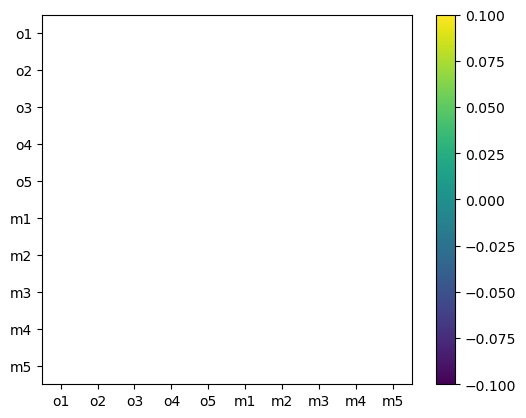

In [41]:
SSE_plot(SSEs)

In [42]:
print(f"Upper left quartal mean: {np.nanmean(SSEs[:5,:5])}")
print(f"Upper right quartal mean: {np.mean(SSEs[:5,5:])}")
print(f"Lower left quartal mean: {np.mean(SSEs[5:,:5])}")
print(f"Lower right quartal mean: {np.nanmean(SSEs[5:,5:])}")

Upper left quartal mean: nan
Upper right quartal mean: nan
Lower left quartal mean: nan
Lower right quartal mean: nan


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


# Some old code which I will use to display the CMs later...

y_pred1 = []
y_true1 = []

y_pred2 = []
y_true2 = []

for inputs, labels in test_loader:
        trained_model1 = trained_model1.to("cpu")
        trained_model2 = trained_model2.to("cpu")
        
        labels = labels.numpy()
        
        output1 = trained_model1(inputs)
        output1 = class_max(output1)
        
        output2 = trained_model2(inputs)
        output2 = class_max(output2)
        
        y_pred1.extend(output1)
        y_true1.extend(labels)
    
        y_pred2.extend(output2)
        y_true2.extend(labels)
        
get_lab_vec = np.vectorize(get_labels)

classes = get_lab_vec(sorted_labels, "sub")

#I chose not to normalize so I get SE of two CMs
cm1 = confusion_matrix(y_true1, y_pred1
                       #, normalize="all"
                        ,labels = sorted_labels
                      )
cm2 = confusion_matrix(y_true2, y_pred2
                       #, normalize="all"
                        ,labels = sorted_labels
                      )

fig, axs = plt.subplots(2, 1, figsize = (15,20))
fig.suptitle('Confusion Matrices', fontsize=24)
axs[0].imshow(cm1, interpolation='none', aspect='auto')
#store for colorbar
im=axs[1].imshow(cm2, interpolation='none', aspect='auto')

#get the level via compact function
def get_super(i):
    return get_labels(create_superclass(i), "super")

def get_ultra(i):
    return get_labels(create_ultraclass(create_superclass(i)), "ultra")

#generator for section borders
def section_border_gen(get_level):
    #squares begin in the upper left corner 
    border_list=[-0.5]
    
    #get_level - get superclass or ultraclass from a subclass index
    state=get_level(sorted_labels[0])
    for i in range(len(sorted_labels)):
        current=get_level(sorted_labels[i])
        #if change in class at the given level - make a border
        if current!=state:
            border_list.append(i-0.5)
        state=get_level(sorted_labels[i])
    
    #smaller than 99.5 so that the line doesn't stand out from the graph
    border_list.append(99.35)
    
    return border_list

section_borders = [section_border_gen(get_super),section_border_gen(get_ultra)]
border_colors = ["red", "green"]
line_widths = [0.7, 1.5]

#level = the borders (at a given level - super/ultra)
#create 4 points to make a square
#draw lines between

for ax in axs:
    for level, color, line_width in zip(section_borders, border_colors, line_widths):
        for i, j in zip(level, level[1:]):
            points = [[i,i], [i,j], [j,j], [j,i]]

            for k, l in zip(points, points[1:]):
                ax.plot(k, l, color=color, linewidth=line_width)

            ax.plot(points[3], points[0], color=color, linewidth=line_width)

fig.colorbar(im, ax=axs.ravel().tolist())

for ax in axs:
    ax.axis('off')
    ax.grid(True)

plt.show()
plt.savefig('confusion1.png')